# Autocorrector Español-México

The following notebook aims to create a simple Spanish-México autocorrect that covers each step of the process, from the compilation of the training corpus to its final test.

## 1.- Gathering wikipedia corpus data
In this section, we will be using gensim python library to build a corpus from the set of Spanish Wikipedia articles, which is freely to use, and tqdm to monitor the entire process.

In [6]:
# Ignoring certain warnings caused by incompatibility of some libraries versions with gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.corpora import WikiCorpus
from tqdm import tqdm

import re
import pickle
from collections import Counter

The following function opens the wiki.xml.bz2 file where the articles are located.

In [7]:
def make_corpus(in_f, out_f):
    output = open(out_f, 'w', encoding="utf8")
    wiki = WikiCorpus(in_f)
    for text in tqdm(wiki.get_texts()):
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')
    output.close()
    print('Processing complete!')

Calling the function with the path of the wiki file and the new document path will begin the process of making the corpus (Uncomment the row in the below section)

In [8]:
wiki_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/eswiki-latest-pages-articles.xml.bz2"
corpus_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/wiki_es.txt"

# make_corpus(wiki_path, corpus_path)

1591007it [1:05:32, 404.60it/s]


Processing complete!


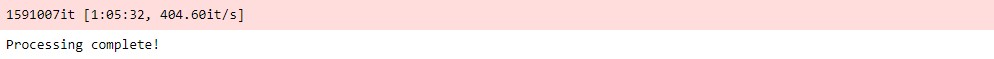

## 2.- Checking wikipedia corpus data
The following section is going to be used to check the corpus lines opening the file we just former created 

In [10]:
corpus_file = open(out_f, 'r', encoding='utf8')

# Number of lines to check in the corpus
lines_check = 5

for lines in range(lines_check):
    text = corpus_file.readline()
    print(text)

corpus_file.close()

andorra oficialmente principado de andorra es un micro estado soberano sin litoral ubicado en el suroeste de europa entre españa francia en el límite de la península ibérica se constituye en estado independiente de derecho democrático social cuya forma de gobierno es el coprincipado parlamentario su territorio está organizado en siete parroquias con una población total de habitantes de febrero de su capital es andorra la vieja con sus km² de extensión territorial andorra es el micro estado más grande de europa está situado en los pirineos entre españa francia tiene una altitud media de limita por el sur con españa con la provincia catalana de lérida por el norte con francia con los departamentos de ariège pirineos orientales occitania pertenece culturalmente la europa latina su sistema político es una democracia parlamentaria cuyos jefes de estado son los copríncipes de andorra el obispo de urgel el presidente de francia el jefe de gobierno es el presidente del gobierno de andorra el i

## 3.- Cleaning the corpus
Spanish language has a lot of variants depending on the region, in this specific project we are interested in México. Furthermore, we will select only the words that contain characters used in this region (i.e; a, b, c, d, e, f, g, h, i, j, k, l, m, n, ñ, o, p, q, r, s, t, u, v, w, x, y, z, á, é, í, ó, ú, ü), which is the vocabulary.

Dividing the documents into words, and using the RegEx library flags will do the work. Every text cleaned will be appended into a new document called wiki_clean_es.txt

In [11]:
def clean_row(w):
    text_divided = w.split(' ')
    clean_text = []
    # Create a dictionary to convert the vocabulary (characters) to integers
    vocab = 'abcdefghijklmnñopqrstuvwxyzáéíóúü'
    for word in text_divided:
        x = [0 for word_spell in word if not re.search(word_spell, vocab)]
        if len(x) == 0:
            clean_text.append(word)
    return " ".join(clean_text)

def clean_corpus(f_in, f_out):
    clean_file = open(f_out, 'a', encoding='utf8')
    with open(f_in, 'r', encoding='utf-8') as f:
        text = f.readlines()
    for lines in tqdm(text):
        clean_file.write(f"{clean_row(lines)}\n")

100%|█████████████████████████████████████████████████████████████████████| 1591007/1591007 [1:34:28<00:00, 280.70it/s]


In [ ]:
clean_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/wiki_clean_es.txt"

# clean_corpus(corpus_path, clean_path)

## 4.- Creating the text vocabulary and obtain probabilities
As stated before, we will calculate the probability that each word is in a sentence to serve as the basis for the autocorrect.

In the previous section we cleaned the words to the only ones that contain valid characters in Mexico. But we need to be sure that those words are meaningful. To be solve the problem, we will use the RAE (Real Academia Española) dictionary, also cleaning it to contain only words valid in México.

In [16]:
def get_vocab(f_in, f_path, f_rae):
    # Load RAE Dictionary
    with open(f_rae, 'r', encoding='utf-8') as g:
        # Split RAE bDictionary into words
        rae_dict = g.read().split('\n')
        letters = 'abcdefghijklmnñopqrstuvwxyzáéíóúü'
        clean_rae_dict = []
        # Clean RAE Dictionary
        for word in rae_dict:
            word = re.sub('\d+', '', word)
            word = re.sub('[.()-]', '', word)
            x = [0 for word_spell in word if not re.search(word_spell, letters)]
            if len(x) == 0:
                clean_rae_dict.append(word)
            else:
                continue
        # Create the initial vocabulary
        g.close()
        words_freq = {}
        for word in clean_rae_dict:
            words_freq[word] = 1

    # Load corpus file
    with open(f_in, 'r', encoding='utf-8') as f:
        text = f.readlines()

    # Analyze the file
    for lines in tqdm(text):
        # Find all unique words in the text
        words = re.findall('\w+', lines)
        # Compute the frequency of every word
        line_word_freq = Counter(words)
        # Append new words to dictionary
        for word in line_word_freq:
            if word in words_freq:
                words_freq[word] += line_word_freq[word]
    f.close()

    # Save the original words_freq_dictionary
    with open(f"{f_path}/raw_words_freq.pkl", 'wb') as g:
        pickle.dump(words_freq, g)
        g.close()
        
    # Number of words used for the final dictionary
    dictionary_n_words = 250000
    n_words(dictionary_n_words, words_freq, f_path)

The following function restricts the vocabulary length to the desired number, in this case it will be set to 250,000 words. It saves 3 instances, the probabilities of every word to be in the text, the vocabulary, and the total number of aparitions of the word in the text corpus.

## 5.- Creating the text vocabulary and obtain probabilities

In [17]:
def n_words(n, words_freq, f_path):
    words_freq = Counter(words_freq)
    # Find the n most common words
    word_most_common = words_freq.most_common()[:n]

    # Create a new dictionary with the words
    word_freq_dict = {}
    for word in word_most_common:
        word_freq_dict[word[0]] = word[1]
    # Create final vocabulary
    vocab = set(word for word in word_freq_dict)
    Total = sum(word_freq_dict.values())

    print(word_most_common)

    # Probabilities of every word
    probs = {}
    for k in word_freq_dict.keys():
        probs[k] = word_freq_dict[k]/Total

    # Save the probabilities of every word
    with open(f"{f_path}/probs_es.pkl", 'wb') as f1:
        pickle.dump(probs, f1)
        f1.close()
    #Save the vocabulary
    with open(f"{f_path}/vocab_es.pkl", 'wb') as f2:
        pickle.dump(vocab, f2)
        f2.close()
    # Save the dictionary of frequent words
    with open(f"{f_path}/word_freq_es.pkl", 'wb') as f3:
        pickle.dump(word_freq_dict, f3)
        f3.close()

In [18]:
files_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector"
rae_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/RAE_dic.txt"

get_vocab(clean_path, files_path, rae_path)

100%|██████████████████████████████████████████████████████████████████████| 1591007/1591007 [11:37<00:00, 2282.24it/s]


[('de', 76445661), ('la', 35546908), ('en', 31120020), ('el', 26957557), ('del', 13462694), ('que', 13227041), ('los', 12024135), ('se', 9567413), ('por', 8483052), ('un', 8072018), ('con', 7735562), ('las', 7324840), ('una', 7121504), ('su', 6577277), ('categoría', 5683861), ('como', 5061603), ('para', 5034749), ('es', 4926975), ('al', 4761226), ('más', 2655625), ('no', 2602120), ('sus', 2070757), ('también', 1946298), ('lo', 1909961), ('entre', 1701963), ('año', 1395382), ('este', 1366955), ('dos', 1257209), ('desde', 1220789), ('sobre', 1195604), ('durante', 1142905), ('pero', 1121022), ('hasta', 1107798), ('le', 1083388), ('son', 1066555), ('esta', 1054258), ('parte', 1052204), ('ciudad', 1005001), ('san', 1003519), ('ha', 999986), ('donde', 989430), ('sin', 976645), ('era', 954181), ('después', 953532), ('primera', 929467), ('ser', 928189), ('nacional', 828604), ('cuando', 822191), ('club', 786989), ('gran', 758617), ('historia', 755380), ('primer', 693887), ('siglo', 678682), ('e

## 6.- Generating possible candidates of the correct word
To 

In [61]:
def sentence_autocorrect(sentence):
    new_sentence = sentence.split(' ')
    sentence_clean = []
    if len(new_sentence) > 0:
        for word in new_sentence:
            if word == '':
                continue
            predictions = check(word)
            sentence_clean.append(predictions)
        print(' '.join(sentence_clean))

In [62]:
def check(word):
    probs_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/probs_es.pkl"
    vocab_path = "C:/Python Projects/GitHub/Portfolio/NLP (Natural Languaje Processing)/Autocorrector/vocab_es.pkl"
    probs = pickle.load(open(probs_path, 'rb'))
    vocab = pickle.load(open(vocab_path, 'rb'))
    if word in vocab:
        return (word)
    candidates = level_one_edits(word) or level_two_edits(word) or [word]
    valid_candidates = [w for w in candidates if w in vocab]
    if len(valid_candidates) > 0:
        return sorted([(c, probs[c]) for c in valid_candidates], key=lambda tup: tup[1], reverse=True)[0][0]
    else:
        return (word)

In [63]:
def l_one_edits(word):
    letters = 'abcdefghijklmnñopqrstuvwxyzáéíóúü'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [l + r[1:] for l, r in splits if r]
    swaps = [l + r[1] + r[0] + r[2:] for l, r in splits if len(r) > 1]
    replaces = [l + c + r[1:] for l, r in splits if r for c in letters]
    inserts = [l + c + r for l, r in splits for c in letters]
    return set(deletes + swaps + replaces + inserts)

def l_two_edits(word):
    return set(e2 for e1 in l_one_edits(word) for e2 in l_one_edits(e1))

Finally, we are able to try our model!!

We will validate the function of this autocorrect calling the function with the desired string, in this example we will verify the following sentence:

hoal munbo oy es un beun dia  --> hola mundo hoy es un buen día

In [64]:
sentence_autocorrect('hoal munbo oy es un beun día')

hola mundo hoy es un buen día


Which corresponds to the correct spelling of the sentence